<a href="https://colab.research.google.com/github/Salvoaf/BreastCancerClassification/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
import csv

In [ ]:
import os
from google.colab import files
files.upload()
!pip install kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

In [7]:
from os import listdir

base_path = "../content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [17]:
healthy_patch =  "../content/healthy_patch"
cancer_patch =  "../content/cancer_patch"
!mkdir healthy_patch
!mkdir cancer_patch

mkdir: cannot create directory ‘healthy_patch’: File exists
mkdir: cannot create directory ‘cancer_patch’: File exists


In [ ]:
import shutil

first = True
check_dim = True
for patches_each_patient in folder:
  path_patient = base_path +"/"+ patches_each_patient  #"../content/IDC_regular_ps50_idx5/id_patient"
  classes = listdir(path_patient)
  for c in classes:
    path_patient_class = path_patient +"/"+ c   #"../content/IDC_regular_ps50_idx5/id_patient/class0-1"
    for patch in listdir(path_patient_class):
      path_patient_patch = path_patient_class + "/" + patch
      if c == "0":
        shutil.copy(path_patient_patch, healthy_patch)
      elif c == "1":
        shutil.copy(path_patient_patch, cancer_patch)
      if first == False:
        if img.shape != mpimg.imread(path_patient_patch).shape:
          check_dim = False
total_cancer_patches = listdir(cancer_patch)
total_healthy_patches = listdir(healthy_patch)
total_patches = total_cancer_patches + total_healthy_patches

print("Number of cancer patches: " + str(len(total_cancer_patches)))
print("Number of healthy patches: " + str(len(total_healthy_patches))) 
print("Totla number patches: "+ str(len(total_patches)))

print("All image have same size: "+ str(check_dim))

In [32]:
print("Number of cancer patches: " + str(len(total_cancer_patches)))
print("Number of healthy patches: " + str(len(total_healthy_patches))) 
print("Totla number patches: "+ str(len(total_patches)))

Number of cancer patches: 78786
Number of healthy patches: 198739
Totla number patches: 277525


#Split the dataset

In [67]:
def split_dataset(dataset, dataset_size, train_percentage=0.6, val_percentage=0.2, test_percentage=0.2, shuffle=True):
  """
    split_dataset splits the dataset into training, validation and test sets.

    :param dataset: a list representing the whole dataset
    :param dataset_size: number of elements in the dataset
    :param train_percentage: the percentage of the dataset that will be used for training
    :param val_percentage: the percentage of the dataset that will be used for validation
    :param test_percentage: the percentage of the dataset that will be used for testing
    :param shuffle: if True the elements of the dataset will be randomly shuffled
    :return: three lists representing the training, validation and test sets
  """
  if train_percentage + val_percentage + test_percentage != 1:
    print('Total of percentages must be 1')
    return None, None, None
  
  if shuffle:
    random.shuffle(dataset)
    
  train_size = int(train_percentage * dataset_size)
  val_size = int(val_percentage * dataset_size)

  train_set = dataset[0:train_size]
  val_set = dataset[train_size:train_size+val_size]
  test_set = dataset[train_size+val_size:dataset_size]
    
  return train_set, val_set, test_set

In [68]:
random.seed(24) # seed is specified to always obtain the same results
training_set, validation_set, test_set = split_dataset(total_patches, len(total_patches))

num_training_samples = len(training_set)
num_validation_samples = len(validation_set)
num_test_samples = len(test_set)

print("Number of samples in the training set: " + str(num_training_samples))
print("Number of samples in the validation set: " + str(num_validation_samples))
print("Number of samples in the test set: " + str(num_test_samples))

Number of samples in the training set: 166515
Number of samples in the validation set: 55505
Number of samples in the test set: 55505


# Solving the Unbalanced Classes Issue
As we can see from the histogram below, the number of images for the two classes is not the same. 

Number of cancer cell images: 119436
Number of normal cell images: 47079
True


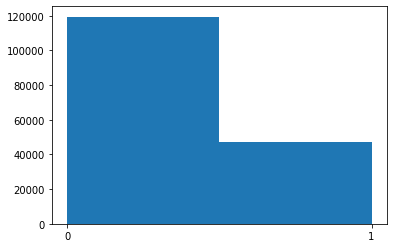

In [69]:
healthy_samples = [entry for entry in training_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in training_set if entry.split("_")[4][5] == '1']

labels = [entry.split("_")[4][5] for entry in training_set]
_ = plt.hist(labels, bins=2)


print("Number of healthy patches: " + str(len(healthy_samples)))
print("Number of cancer images: " + str(len(cancer_samples)))
print((len(healthy_samples)+len(cancer_samples))==num_training_samples)

**We want the classes to have the same number of images, so we need to balance everything**


In [70]:
expected_samples_per_class = num_training_samples//2
print("Number of expected images per class: " + str(expected_samples_per_class))
print("Number of cancer cell images: " + str(len(healthy_samples)))

Number of expected images per class: 83257
Number of cancer cell images: 119436


For the class containing multiple samples we will do a subsampling

In [71]:
healthy_samples = random.sample(healthy_samples, expected_samples_per_class)
print("Number of sampled healthy patches: " + str(len(healthy_samples)))

Number of sampled healthy patches: 83257


**For the class containing fewer samples we will do an augmentation**

In [72]:
cancer_samples_needed = expected_samples_per_class - len(cancer_samples)
new_cancer_samples = random.sample(cancer_samples, cancer_samples_needed)
cancer_samples= cancer_samples + new_cancer_samples
training_set = cancer_samples + healthy_samples
print("Number of sampled normal cell images to perform augmentation: " + str(len(new_cancer_samples)))
print("Final number of normal cell images: " + str(len(cancer_samples)))

Number of sampled normal cell images to perform augmentation: 36178
Final number of normal cell images: 83257


**Balanced training**

Number of cancer cell images: 83257
Number of normal cell images: 83257
False


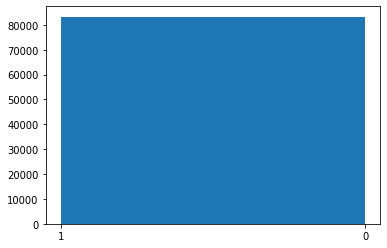

In [73]:
healthy_samples = [entry for entry in training_set if entry.split("_")[4][5] == '0']
cancer_samples = [entry for entry in training_set if entry.split("_")[4][5] == '1']

labels = [entry.split("_")[4][5] for entry in training_set]
_ = plt.hist(labels, bins=2)


print("Number of healthy patches: " + str(len(healthy_samples)))
print("Number of cancer images: " + str(len(cancer_samples)))